In [ ]:
!pip install stable-baselines==2.9.0

In [ ]:
import numpy as np

import datetime
import time
from collections import deque

import torch as T
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.distributions import Categorical
from torch.optim.lr_scheduler import LambdaLR

from stable_baselines.common.misc_util import set_global_seeds
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack

import matplotlib.pyplot as plt

In [ ]:
ENV_NAME = 'BreakoutNoFrameskip-v4'
NENV = 8
ROLLOUT_LENGTH = 128
LATENT_SIZE = 256
MB_SPLIT = 4
MB_EPOCHS = 4
TOTAL_TIMESTEPS = 5e6
GAMMA = 0.99
CLIP = 0.2
DEVICE = T.device('cuda' if T.cuda.is_available() else 'cpu')
SEED = 420 
set_global_seeds(SEED)

# Environment

In [4]:
env = make_atari_env(ENV_NAME, num_env=NENV, seed=SEED)
env = VecFrameStack(env, n_stack=4)

in_dim = env.observation_space.shape
in_dim=(in_dim[2],in_dim[0],in_dim[1])  # torch ordering
num_actions = env.action_space.n

print('Observation shape: ', in_dim)
print('Number of actions: ', num_actions)

Observation shape:  (4, 84, 84)
Number of actions:  4


# CNNs

In [0]:
def conv_size(net, in_shape):
    """ util for calculating flat output shape of a given net """
    x = Variable(T.rand(1, *in_shape))
    o = net(x)
    b = (-1, o.size(1), o.size(2), o.size(3))
    return b, o.data.view(1, -1).size(1)

In [0]:
class AutoEncoder(nn.Module):
    """ This is used to *represent* the environment (perception).
        The latent space of this autoencoder is uni-dimensional.
    """
    def __init__(self, input_shape, num_actions, latent_size):
        super().__init__()
        self.c, self.h, self.w = input_shape
        self.num_actions = num_actions
        self.latent_size = latent_size
        
        self.encoder_conv = nn.Sequential(
        nn.Conv2d(self.c, 64, 8, 4),
        nn.ReLU(True),
        nn.Conv2d(64, 32, 4, 2),
        nn.ReLU(True),
        nn.Conv2d(32, 16, 4, 1),
        nn.ReLU(True)
        )

        self.conv_x, self.conv_f = conv_size(self.encoder_conv, input_shape)

        self.encoder_linear = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(self.conv_f, self.latent_size)
        )

        self.decoder_linear = nn.Sequential(
            nn.Linear(self.latent_size, self.conv_f),
            nn.ReLU(True)
        )

        self.decoder_conv = nn.Sequential(
        nn.ConvTranspose2d(16+self.num_actions, 32, 4, 1),  # note num_actions
        nn.ReLU(True),
        nn.ConvTranspose2d(32, 64, 4, 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, self.c, 8, 4)
        )

    def encode(self, x):
        """ *represent* the environment in latent space"""
        x = self.encoder_conv(x)
        x = self.encoder_linear(x)
        return x  # latent code

    def one_hot_3d_action(self, actions):
        _,_,ch,cw = self.conv_x
        cn = len(actions)
        z = np.zeros((len(actions), self.num_actions, ch, cw), dtype=np.float32)
        for i in range(cn):
            z[i,actions[i],:,:] = 1.0
        z = T.from_numpy(z).to(DEVICE)
        return z

    def forward(self, x, actions):
        """ actions is a list of ints describing the actions taken """
        x = self.encoder_conv(x)
        latent = self.encoder_linear(x)
        x = self.decoder_linear(latent)
        x = x.view(self.conv_x)
        # add information about which action we took
        z_action = self.one_hot_3d_action(actions)
        x = T.cat((x, z_action), dim=1)
        x = self.decoder_conv(x)
        return x, latent

In [0]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [0]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    """ This is used to *represent* the environment (perception).
        The latent space of this autoencoder is uni-dimensional.
    """
    def __init__(self, input_shape, num_actions, latent_size):
        super().__init__()
        self.c, self.h, self.w = input_shape
        self.num_actions = num_actions
        self.latent_size = latent_size
        
        self.encoder_conv = nn.Sequential(
        nn.Conv2d(self.c, 64, 8, 4),
        nn.ReLU(True),
        nn.Conv2d(64, 32, 4, 2),
        nn.ReLU(True),
        nn.Conv2d(32, 16, 4, 1),
        nn.ReLU(True)
        )

        self.conv_x, self.conv_f = conv_size(self.encoder_conv, input_shape)

        self.encoder_linear = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(self.conv_f, self.latent_size)
        )

        self.decoder_linear = nn.Sequential(
            nn.Linear(self.latent_size, self.conv_f),
            nn.ReLU(True)
        )

        self.decoder_conv = nn.Sequential(
        nn.ConvTranspose2d(16+self.num_actions, 32, 4, 1),  # note num_actions
        nn.ReLU(True),
        nn.ConvTranspose2d(32, 64, 4, 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, self.c, 8, 4)
        )

    def encode(self, x):
        """ *represent* the environment in latent space"""
        x = self.encoder_conv(x)
        x = self.encoder_linear(x)
        return x  # latent code

    def one_hot_3d_action(self, actions):
        _,_,ch,cw = self.conv_x
        cn = len(actions)
        z = np.zeros((len(actions), self.num_actions, ch, cw), dtype=np.float32)
        for i in range(cn):
            z[i,actions[i],:,:] = 1.0
        z = T.from_numpy(z).to(DEVICE)
        return z

    def forward(self, x, actions):
        """ actions is a list of ints describing the actions taken """
        x = self.encoder_conv(x)
        latent = self.encoder_linear(x)
        x = self.decoder_linear(latent)
        x = x.view(self.conv_x)
        # add information about which action we took
        z_action = self.one_hot_3d_action(actions)
        x = T.cat((x, z_action), dim=1)
        x = self.decoder_conv(x)
        return x, latent

In [0]:
class ACC(nn.Module):
    """ This is used to learn *behaviour* from our environment representation.
        ActorCriticCritic uses two value heads/critics. One criticises the 
        extrinsic reward. The other criticises the intrinsic reward.
    """
    def __init__(self, num_inputs, num_actions):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(num_inputs, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True)
        )

        self.actor = nn.Linear(512, num_actions)
        self.critic = nn.Linear(512, 1)
        # self.int_critic = nn.Linear(512, 1)

    def forward(self, x):
        x = self.linear(x)
        return self.actor(x), self.critic(x)  #, self.int_critic(x)

In [0]:
class ACTOR(nn.Module):
    """ This is used to learn *behaviour* from our environment representation.
        ActorCriticCritic uses two value heads/critics. One criticises the 
        extrinsic reward. The other criticises the intrinsic reward.
    """
    def __init__(self, num_inputs, num_actions):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(num_inputs, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True)
        )

        self.actor = nn.Linear(512, num_actions)

    def forward(self, x):
        x = self.linear(x)
        return self.actor(x)

class CRITIC(nn.Module):
    """ This is used to learn *behaviour* from our environment representation.
        ActorCriticCritic uses two value heads/critics. One criticises the 
        extrinsic reward. The other criticises the intrinsic reward.
    """
    def __init__(self, num_inputs, num_actions):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(num_inputs, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True)
        )

        self.critic = nn.Linear(512, 1)

    def forward(self, x):
        x = self.linear(x)
        return self.critic(x)

# Rollout handling

In [0]:
class Rollouts:

    def __init__(self):
        self.empty_memory()

    def store_transition(self, ob, logp, action, reward, value, done, info):
        self.obs.append(ob)
        self.logps.append(logp)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        self.dones.append(done)
        for i in info:
            if i.get('episode'): 
                self.infos['l'].append(i['episode']['l'])
                self.infos['r'].append(i['episode']['r'])

    def empty_memory(self):
        self.obs      = []
        self.obs_d1   = []  # t+1
        self.obs_d2   = []  # t+2
        self.logps    = []
        self.actions  = []
        self.rewards  = []
        self.values   = []
        self.dones    = []
        self.infos   = {'l':[], 'r':[]}

    def preprocess_obs(self, arr):
        """ Normalize and permute array :param arr: to make it Torch compatible """
        return np.moveaxis(arr.astype(np.float32) / 255., -1, 1)

    def flatten(self, x, flat_n, to_tensor=True):
        """ flatten x *in place* to (flat_n, ...)
            :param to_tensor: if true, x is cast to a torch tenor """
        x = np.asarray(x, np.float32).reshape((flat_n,)+x[0].shape[1:])
        if to_tensor: 
            return T.from_numpy(x).to(DEVICE)
        return x

    def flatten_rollout(self):
        """ flatten trajectory buffers to (NENV*ROLLOUT_LENGTH-1, ...)"""
        N = (ROLLOUT_LENGTH-1)*NENV
        self.obs     = self.flatten(self.obs, N)
        self.obs_d1  = self.flatten(self.obs_d1, N)
        self.obs_d2  = self.flatten(self.obs_d2, N)
        self.logps   = self.flatten(self.logps, N)
        self.actions = self.flatten(self.actions, N)
        self.rewards = self.flatten(self.rewards, N)
        self.values  = self.flatten(self.values, N)


    def generator(self):

        ob = self.preprocess_obs(env.reset())  # initial observation
        rollout_num = 0

        while True:
            rollout_num += 1
            
            with T.no_grad():
                tob = T.from_numpy(ob).to(DEVICE)
                z1 = ae_delta_1.encode(tob)      # latent repr of St+1
                z2 = ae_delta_2.encode(tob)      # latent repr of St+2
                z_join = T.cat((z1,z2), dim=1)   # joint latent repr

                pi     = actor(z_join)           # action scores
                v      = critic(z_join)          # value
                dist   = Categorical(logits=pi)  # to multinomial (discreet)
                action = dist.sample()
                log_pi = dist.log_prob(action).cpu().numpy()
                action = action.cpu().numpy()
                v = v.cpu().numpy()[:, 0]
            
            new_ob, reward, done, info = env.step(action)
            self.store_transition(ob, log_pi, action, reward, v, done, info)
            ob = self.preprocess_obs(new_ob)

            if rollout_num % ROLLOUT_LENGTH == 0:
                # bootstrap reward from critic predicted value function
                # note that v is V(S_{t+1}) - TD(1) (one step returns)
                with T.no_grad():
                    tob = T.from_numpy(ob).to(DEVICE)
                    z1 = ae_delta_1.encode(tob)      # latent repr of St+1
                    z2 = ae_delta_2.encode(tob)      # latent repr of St+2
                    z_join = T.cat((z1,z2), dim=1)   # joint latent repr
                    flags = 1 - done   # should we bootstrap or not?
                    v = critic(z_join)  # value of next state TD(1)
                    v = v.cpu().numpy()[:, 0] * flags

                # reward discounting / creit assignment
                self.rewards[-1] += GAMMA * v
                for i in reversed(range(ROLLOUT_LENGTH - 1)):
                    flags = 1 - self.dones[i]
                    self.rewards[i] += GAMMA * self.rewards[i+1] * flags

                self.obs_d1 = self.obs[1:]         # for ae_delta_1
                self.obs_d2 = self.obs[2:] + [ob]  # for ae_delta_2
                del self.obs[-1]
                del self.logps[-1]
                del self.actions[-1]
                del self.values[-1]
                del self.rewards[-1]

                # reshape and cast to torch tensors (rollouts)
                self.flatten_rollout()
                yield self.obs, self.obs_d1, self.obs_d2, self.logps, self.actions, self.values, self.rewards, self.infos
                self.empty_memory()

# Logging

In [0]:
class Logger:

    def __init__(self,):
        self.total_updates = int(TOTAL_TIMESTEPS // (NENV * ROLLOUT_LENGTH))
        self.sma_ep_len    = deque(maxlen=50)
        self.sma_ep_reward = deque(maxlen=50)
        self.sma_pgloss    = deque(maxlen=250)
        self.sma_vloss     = deque(maxlen=250)
        self.sma_entropy   = deque(maxlen=250)
        self.sma_loss      = deque(maxlen=250)
        self.sma_ae1       = deque(maxlen=250)
        self.sma_ae2       = deque(maxlen=250)
        self.n_ep     = 0  # number of games/episodes
        self.n_iters  = 0  # number of weight updates
        self.n_frames = 0  # number of environment steps
        self.max_reward = -np.inf
        self.start_time = time.time()
        # self.tb = TensorBoardColab()

    def update(self, mb_info, pgloss, vloss, ent, loss, ae1_loss, ae2_loss, print_rate=250):
        """ :param mb_info: dict containing episode lengths and rewards (if any) 
            :param print_rate: how often to print to stdout and flush TensorBoard
            This saves the model to disk if we obtain a new high score.
        """
        for i in range(len(mb_info['r'])):
            ep_len = mb_info['l'][i]
            ep_r   = mb_info['r'][i]
            self.sma_ep_reward.append(ep_r)
            self.sma_ep_len.append(ep_len)
            # self.tb.save_value('Episode Length', 'ep_len', self.n_frames, ep_len)
            # self.tb.save_value('Episode Reward', 'ep_r', self.n_frames, ep_r)
            if ep_r > self.max_reward:
                if self.n_frames > 500000:
                    ppo_save_path = SAVE_PATH.format(ENV_NAME+'-PPO', ep_r)
                    rnd_save_path = SAVE_PATH.format(ENV_NAME+'-RND', ep_r)
                    T.save(ppo_network.state_dict(), ppo_save_path)  # save model to disk
                    T.save(rnd_network.state_dict(), rnd_save_path)  # save model to disk
                self.max_reward = ep_r
            self.n_ep += 1


        self.n_iters += 1
        self.n_frames += (ROLLOUT_LENGTH*NENV)

        self.sma_pgloss.append(pgloss)
        self.sma_vloss.append(vloss)
        self.sma_entropy.append(ent)
        self.sma_loss.append(loss)
        self.sma_ae1.append(ae1_loss)
        self.sma_ae2.append(ae2_loss)

        # log raw values to TensorBoard
        # self.tb.save_value('Loss', 'loss', self.n_frames, loss)
        # self.tb.save_value('Entropy', 'ent', self.n_frames, ent)
        # self.tb.save_value('Value Loss', 'vloss', self.n_frames, vloss)
        # self.tb.save_value('PG Loss', 'pgloss', self.n_frames, pgloss)
        # self.tb.save_value('Intrinsic Loss', 'intrinsic', self.n_frames, intr)

        if self.n_iters % print_rate == 0:
            # self.tb.flush_line('ep_len')
            # self.tb.flush_line('ep_r')
            # self.tb.flush_line('ent')
            # self.tb.flush_line('vloss')
            # self.tb.flush_line('pgloss')
            # self.tb.flush_line('loss')
            # self.tb.flush_line('intrinsic')
            self.report()

    def report(self):
        """ print stats to stdout """
        if len(self.sma_ep_len) <= 0:
            return
        elapsed_time = time.time()-self.start_time
        fps = int(self.n_frames / elapsed_time)
        eta = (TOTAL_TIMESTEPS - self.n_frames) * (elapsed_time / self.n_frames)
        eta_str = str(datetime.timedelta(seconds=int(eta)))
        print('-'*10, self.n_iters, '/', self.total_updates, '-'*10)
        print(f'SMA 50 Length: {sum(self.sma_ep_len)/len(self.sma_ep_len)}')
        print(f'SMA 50 Reward: {sum(self.sma_ep_reward)/len(self.sma_ep_reward)}')
        print(f'SMA 250 pgloss: {sum(self.sma_pgloss)/len(self.sma_pgloss)}')
        print(f'SMA 250 vloss: {sum(self.sma_vloss)/len(self.sma_vloss)}')
        print(f'SMA 250 ae1 loss: {sum(self.sma_ae1)/len(self.sma_ae1)}')
        print(f'SMA 250 ae2 loss: {sum(self.sma_ae2)/len(self.sma_ae2)}')
        print(f'SMA 250 loss: {sum(self.sma_loss)/len(self.sma_loss)}')
        print(f'SMA 250 entropy: {sum(self.sma_entropy)/len(self.sma_entropy)}')
        print(f'FPS: {fps}')
        print(f'ETA: {eta_str}')
        print(f'Max reward: {self.max_reward}')
        print(f'Number of games: {self.n_ep}')

# Train

In [0]:
# this autoencoder predicts S_{t+1}.
ae_delta_1 = AutoEncoder(in_dim, num_actions, LATENT_SIZE).to(DEVICE)
ae_optim_1 = Adam(ae_delta_1.parameters(), 7e-4, eps=1e-5)
T.save(ae_delta_1, 'clone.t')

# this autoencoder predicts S_{t+2}. 
# cloned so latent dynamics are similar.
ae_delta_2 = T.load('clone.t').to(DEVICE)
ae_optim_2 = Adam(ae_delta_2.parameters(), 7e-4, eps=1e-5)

# this is our actor + critic
# input is both latent vectors of above autoencoders.
actor = ACTOR(LATENT_SIZE*2, num_actions).to(DEVICE)
actor_optim = Adam(actor.parameters(), 7e-4, eps=1e-5)

critic = CRITIC(LATENT_SIZE*2, num_actions).to(DEVICE)
critic_optim = Adam(critic.parameters(), 7e-4, eps=1e-5)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type AutoEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
MB_LEN      = int(NENV*(ROLLOUT_LENGTH-1))
SPLIT_LEN   = int(MB_LEN//MB_SPLIT)
NUM_UPDATES = int(TOTAL_TIMESTEPS//MB_LEN)

rgen = Rollouts().generator()

actor_scheduler  = LambdaLR(actor_optim, lambda i: 1 - (i / NUM_UPDATES))
critic_scheduler  = LambdaLR(critic_optim, lambda i: 1 - (i / NUM_UPDATES))
ae_1_scheduler = LambdaLR(ae_optim_1, lambda i: 1 - (i / NUM_UPDATES))
ae_2_scheduler = LambdaLR(ae_optim_2, lambda i: 1 - (i / NUM_UPDATES))

logger = Logger()

In [0]:
for update in range(1, NUM_UPDATES):

    obs, obs_d1, obs_d2, logps, actions, values, rewards, infos = next(rgen)

    # do 100 updates on representation networks
    num_repr = max(50-update, 3)
    print(f'Doing {num_repr} repr updates...')
    for _ in range(num_repr):
        # update representation network S_{t+1}
        pred_ae_1, z1 = ae_delta_1(obs, actions.cpu().numpy().astype(int))
        citerion  = nn.MSELoss()
        loss_ae_1 = citerion(pred_ae_1, obs_d1)    # UNET + DIFFERENCE (not absolute prediction)
        ae_optim_1.zero_grad()
        loss_ae_1.backward()
        nn.utils.clip_grad_norm_(ae_delta_1.parameters(), 0.5)
        ae_optim_1.step()

        # update representation network S_{t+2}
        pred_ae_2, z2 = ae_delta_2(obs, actions.cpu().numpy().astype(int))
        citerion  = nn.MSELoss()
        loss_ae_2 = citerion(pred_ae_2, obs_d2)
        ae_optim_2.zero_grad()
        loss_ae_2.backward()
        nn.utils.clip_grad_norm_(ae_delta_2.parameters(), 0.5)
        ae_optim_2.step()

        # update critic
        z_join  = T.cat((z1.detach(), z2.detach()), dim=1)
        v = critic(z_join)
        v_loss  = ((v - rewards)**2).mean()
        critic_optim.zero_grad()
        v_loss.backward()
        nn.utils.clip_grad_norm_(critic.parameters(), 0.5)
        critic_optim.step()

    # update actor
    adv = rewards - v.detach()
    # adv = (adv - adv.mean()) / (adv.std() + 1e-8)

    # get new latent representations
    z1 = ae_delta_1.encode(obs).detach()
    z2 = ae_delta_2.encode(obs).detach()

    # infer behaviour from learned representation of env
    z_join  = T.cat((z1, z2), dim=1)
    pi      = actor(z_join)
    dist    = Categorical(logits=pi)
    logps   = dist.log_prob(actions)
    
    # losses
    pg_loss = -(logps * adv).mean()
    entropy = dist.entropy().mean()
    loss = pg_loss - 0.01 * entropy
    actor_optim.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(actor.parameters(), 0.5)
    actor_optim.step()
    
    # decrease learning rates linearly
    actor_scheduler.step(update)
    critic_scheduler.step(update)
    ae_1_scheduler.step(update)
    ae_2_scheduler.step(update)

    # log stats
    logger.update(
        infos, pg_loss.item(), v_loss.item(), 
        entropy.item(), loss.item(), 
        loss_ae_1.item(), loss_ae_2.item(), 
        print_rate=5
    )
    if update%5 == 0:
        print('SOFTMAX: ', dist.probs[0])


Doing 49 repr updates...
Doing 48 repr updates...
Doing 47 repr updates...
Doing 46 repr updates...
Doing 45 repr updates...
---------- 5 / 4882 ----------
SMA 50 Length: 185.22857142857143
SMA 50 Reward: 2.2
SMA 250 pgloss: 0.019152600690722464
SMA 250 vloss: 0.12003977596759796
SMA 250 ae1 loss: 0.007770133204758167
SMA 250 ae2 loss: 0.008472253940999508
SMA 250 loss: 0.009988954663276673
SMA 250 entropy: 0.9163646459579468
FPS: 96
ETA: 14:23:18
Max reward: 11.0
Number of games: 35
SOFTMAX:  tensor([0.0158, 0.0878, 0.0100, 0.8865], device='cuda:0',
       grad_fn=<SelectBackward>)
Doing 44 repr updates...
Doing 43 repr updates...
Doing 42 repr updates...
Doing 41 repr updates...
Doing 40 repr updates...
---------- 10 / 4882 ----------
SMA 50 Length: 167.72
SMA 50 Reward: 2.38
SMA 250 pgloss: 0.009352510992903263
SMA 250 vloss: 0.14534263610839843
SMA 250 ae1 loss: 0.005544279422610998
SMA 250 ae2 loss: 0.006202958128415048
SMA 250 loss: 0.0011211581993848085
SMA 250 entropy: 0.823135

KeyboardInterrupt: ignored

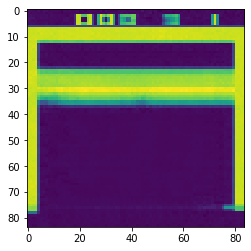

In [0]:
import matplotlib.pyplot as plt

plt.imshow(pred_ae_1.detach().cpu().numpy()[590][0])

In [0]:
for update in range(1, NUM_UPDATES):

    obs, obs_d1, obs_d2, logps, actions, values, rewards, infos = next(rgen)

    for _ in range(MB_EPOCHS):    # perform n updates on each minibatch
        
        for s in range(MB_SPLIT):  # split the batch into n chunks

            indices = slice(s*SPLIT_LEN, s*SPLIT_LEN + SPLIT_LEN)
            s_obs        = obs[indices]
            s_obs_d1     = obs_d1[indices]
            s_obs_d2     = obs_d2[indices]
            s_logps_old  = logps[indices]
            s_actions    = actions[indices]
            s_rewards    = rewards[indices]
            s_values_old = values[indices] 

            # update representation network S_{t+1}
            pred_ae_1, z1 = ae_delta_1(s_obs, s_actions.cpu().numpy().astype(int))
            citerion  = nn.MSELoss()
            loss_ae_1 = citerion(pred_ae_1, s_obs_d1)
            ae_optim_1.zero_grad()
            loss_ae_1.backward()
            nn.utils.clip_grad_norm_(ae_delta_1.parameters(), 0.5)
            ae_optim_1.step()

            # update representation network S_{t+2}
            pred_ae_2, z2 = ae_delta_2(s_obs, s_actions.cpu().numpy().astype(int))
            citerion  = nn.MSELoss()
            loss_ae_2 = citerion(pred_ae_2, s_obs_d2)
            ae_optim_2.zero_grad()
            loss_ae_2.backward()
            nn.utils.clip_grad_norm_(ae_delta_2.parameters(), 0.5)
            ae_optim_2.step()

            # compute intrinsic reward (inefficent TODO)
            int1 = ((s_obs_d1 - pred_ae_1)**2).mean(dim=(1,2,3)) 
            int2 = ((s_obs_d2 - pred_ae_2)**2).mean(dim=(1,2,3)) 
            intrinsic_reward = int1.detach() + int2.detach()
            # extrinsic + intrinsic, baselined for advantage
            adv = s_rewards + 0.2*intrinsic_reward - s_values_old
            adv = (adv - adv.mean()) / (adv.std() + 1e-8)

            # IMPORTANT this is being updated on OUTDATED z -- recompute? TODO TRY THIS FIRST IF NO WORK <<<<<<<<<<<<<<<<<<<<<
            z1 = ae_delta_1.encode(s_obs).detach()
            z2 = ae_delta_2.encode(s_obs).detach()
            # ppo on actor critic
            z_join    = T.cat((z1.detach(),z2.detach()), dim=1)
            pi, v     = acc(z_join)
            v         = v[:, 0]
            dist      = Categorical(logits=pi)
            s_entropy = dist.entropy().mean()
            s_logps_new = dist.log_prob(s_actions)

            # calculate surrogate loss (ratio == 1 on first iter, ln cancels)
            ratio   = (s_logps_new - s_logps_old).exp() # e^x / e^x == e^(x-y)
            L_CPI   = adv * ratio
            L_CLAMP = adv * (ratio.clamp(1-CLIP, 1+CLIP))
            L_CLIP  = -T.min(L_CPI, L_CLAMP).mean()
            
            # caculate value loss (try clamping as experiment)  # TODO : IMPORTANT TO SCALE INT HERE TOO?
            V_L = ((v-(s_rewards + 0.2*intrinsic_reward))**2).mean()
            
            # final loss
            loss = L_CLIP + 0.5 * V_L - 0.02 * s_entropy

            acc_optim.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(acc.parameters(), 0.5)
            acc_optim.step()
    
    # decrease learning rates linearly
    acc_scheduler.step(update)
    ae_1_scheduler.step(update)
    ae_2_scheduler.step(update)

    # log stats
    logger.update(
        infos, L_CLIP.item(), V_L.item(), 
        s_entropy.item(), loss.item(), 
        intrinsic_reward.mean().item(), 
        print_rate=5
    )
    if update%5 == 0:
        print('SOFTMAX: ', dist.probs[0])


---------- 5 / 976 ----------
SMA 50 Length: 199.21875
SMA 50 Reward: 2.0
SMA 250 pgloss: -0.005999824864557013
SMA 250 vloss: 0.08127210550010204
SMA 250 intrinsic: 0.004866595193743706
SMA 250 loss: 0.010406126081943513
SMA 250 entropy: 1.211505126953125
FPS: 334
ETA: 0:49:29
Max reward: 14.0
Number of games: 32
SOFTMAX:  tensor([0.1200, 0.1907, 0.4588, 0.2306], device='cuda:0',
       grad_fn=<SelectBackward>)
---------- 10 / 976 ----------
SMA 50 Length: 194.08
SMA 50 Reward: 1.78
SMA 250 pgloss: -0.00422924869635608
SMA 250 vloss: 0.09672766830772161
SMA 250 intrinsic: 0.004486960940994322
SMA 250 loss: 0.01947435149922967
SMA 250 entropy: 1.2330117702484131
FPS: 344
ETA: 0:47:51
Max reward: 14.0
Number of games: 59
SOFTMAX:  tensor([0.1625, 0.2177, 0.3756, 0.2443], device='cuda:0',
       grad_fn=<SelectBackward>)
---------- 15 / 976 ----------
SMA 50 Length: 189.38
SMA 50 Reward: 1.52
SMA 250 pgloss: -0.004090286040445789
SMA 250 vloss: 0.10791716116170089
SMA 250 intrinsic: 0.0